# Loop Hydrodynamics
Configure loop hydrodynamics with HYDRAD. We need to write an interface to the HYDRAD model that can both configure the simulations and load the results back in

In [1]:
import sys
import glob

import numpy as np
from scipy.interpolate import splprep,splev
import h5py
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
import sunpy.sun.constants as sun_const
from scipy.interpolate import splrep,splev
from IPython.display import HTML

from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand
from hydrad_tools.visualize import plot_strand,animate_strand

import synthesizAR
from synthesizAR.interfaces.ebtel import power_law_transform,calculate_free_energy

from hydrad_interface import HYDRADInterface
from make_uniform_grid import interpolate_to_uniform_grid,save_to_hdf5

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/hydrad_tools/configure/configure.py:20: UserWarning: GitPython not installed. Cannot retrieve base copy from GitHub.
  warnings.warn('GitPython not installed. Cannot retrieve base copy from GitHub.')


Restore the field

In [2]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/hi_c_simulation/noaa12712_base/')

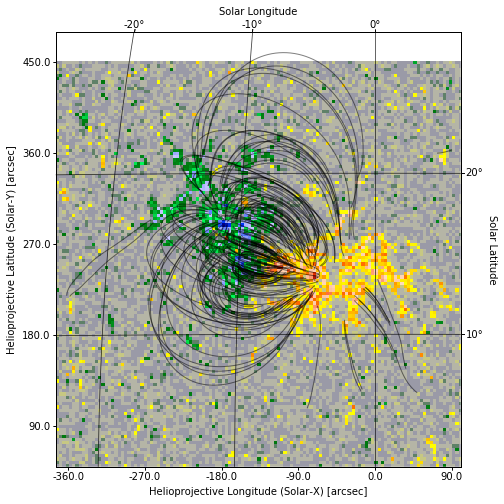

In [4]:
active_region.peek(line_frequency=5)

## Loading the Simulation Data
We have configured and run the results on the davinci and nots Rice clusters and downloaded the data to nikola. 

The data have been reduced to 1 HDF5 file per run with the electron temperature, ion temperature, density, velocity, time, and coordinate all saved as separate datasets. Rather than rebuild a new file with all of these results, each loop will have a separate savefile

Now, instantiate the interface for HYDRAD. We can use a dummy configuration and paths because we don't need to actually configure anything.

In [5]:
interface = HYDRADInterface({}, '', '')

Two primary things to do when loading in the data:

1. set the parameters savefile for each loop to the uniform grid HDF5 file
2. reinterpolate the Loop coordinates to the simulation resolution

Then, we need to save the field with the new interpolated loops.

In [6]:
uniform_grid_file = '/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/reduced_results/{}_uniform.h5'
parameters_savefile = '/storage-home/w/wtb2/data/hi_c_simulation/loop_parameters.h5'

In [7]:
with h5py.File(parameters_savefile, 'w') as hf_primary:
    with ProgressBar(len(active_region.loops),ipython_widget=True,) as prog:
        for loop in active_region.loops:
            # Assign parameter filename
            loop.parameters_savefile = parameters_savefile
            # Add link to existing file in new file
            hf_primary[loop.name] = h5py.ExternalLink(uniform_grid_file.format(loop.name),'/')
            # Reinterpolate loop properties based on HYDRAD resolution
            # Take transpose of all quantities to be consistent with synthesizAR convention
            # In the future, this transpose rewriting part won't be necessary because the 
            # uniform grid script has been fixed
            #quantities = ['electron_temperature', 'ion_temperature', 'density', 'velocity']
            with h5py.File(uniform_grid_file.format(loop.name), 'a') as hf:
                n_interp = hf['coordinate'].shape[0]
           #     for q in quantities:
           #         data = u.Quantity(hf[q], hf[q].attrs['unit'])
           #         del hf[q]
           #         dset = hf.create_dataset(q, data=data.value.T)
           #         dset.attrs['unit'] = data.unit.to_string()
            ## Interpolate loop coordinates
            nots, _ = splprep(loop.coordinates.cartesian.xyz.value)
            coord_xyz = u.Quantity(splev(np.linspace(0,1,n_interp),nots), loop.coordinates.cartesian.xyz.unit)
            ## Interpolate field strengths
            nots = splrep(loop.field_aligned_coordinate.value,loop.field_strength.value)
            B_mag = splev(np.linspace(loop.field_aligned_coordinate[0].value,
                                      loop.field_aligned_coordinate[-1].value,n_interp),nots)
            B_mag = u.Quantity(np.where(B_mag < 0, 0., B_mag), loop.field_strength.unit)
            # Assign to loop
            loop._coordinates = SkyCoord(x=coord_xyz[0,:],y=coord_xyz[1,:],z=coord_xyz[2,:],
                                         frame=loop._coordinates.frame,representation='cartesian')
            loop._field_strength = B_mag
            prog.update()

FloatProgress(value=0.0)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


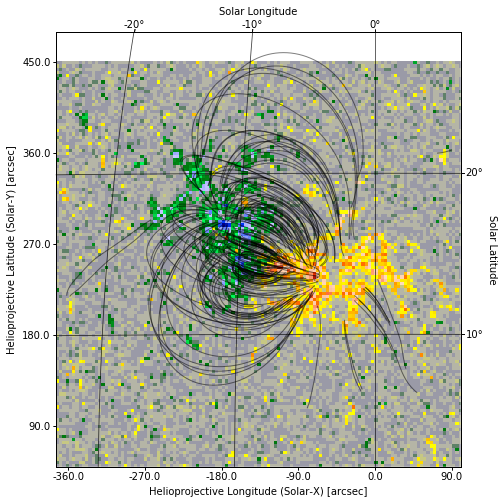

In [8]:
active_region.peek(line_frequency=5)

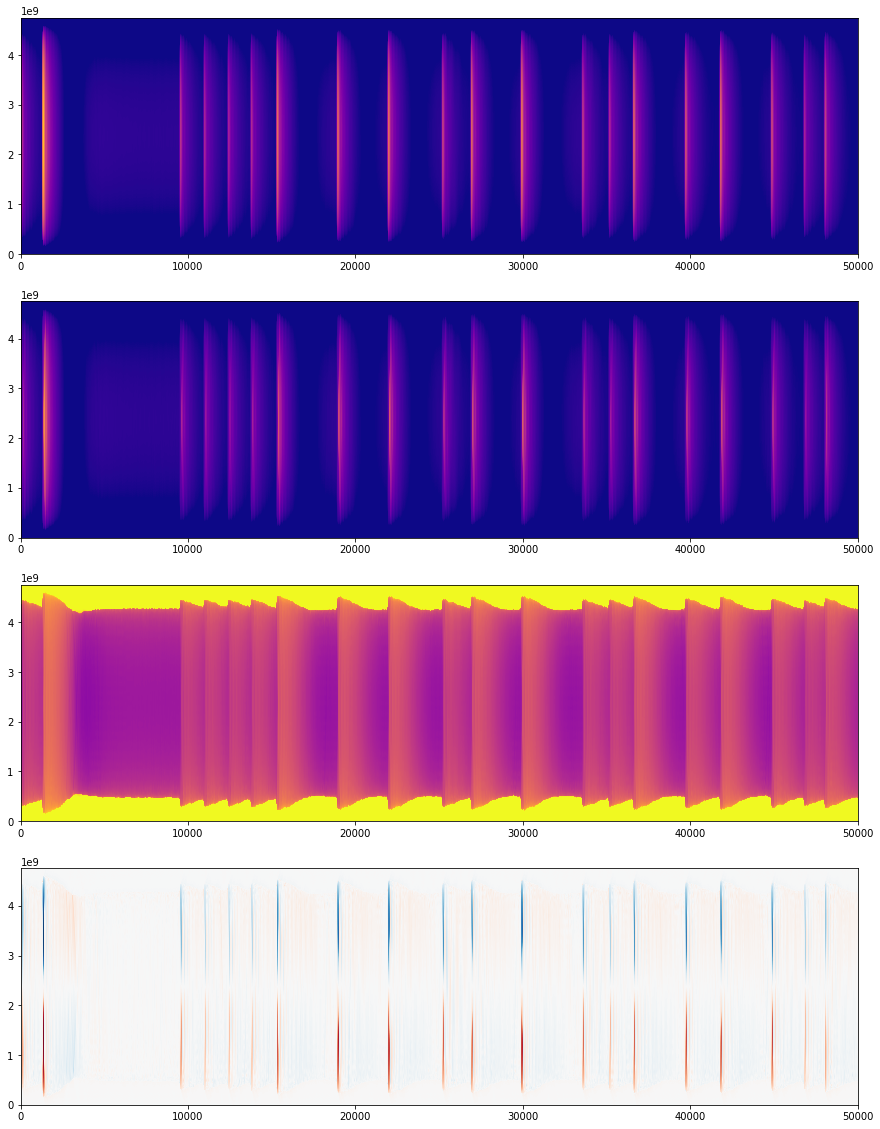

In [10]:
plt.figure(figsize=(15,20))
plt.subplot(411)
smesh,tmesh = np.meshgrid(active_region.loops[100].field_aligned_coordinate.value,
                          active_region.loops[100].time.value,)
plt.pcolormesh(tmesh,smesh,active_region.loops[100].electron_temperature,
               cmap='plasma',vmin=1e6,vmax=1e7)
#plt.xlim(3.1e4,3.3e4)
plt.subplot(412)
plt.pcolormesh(tmesh,smesh,active_region.loops[100].ion_temperature,
               cmap='plasma',vmin=1e6,vmax=1e7)
#plt.xlim(3.1e4,3.3e4)
plt.subplot(413)
plt.pcolormesh(tmesh,smesh,active_region.loops[100].density,
               cmap='plasma',norm=matplotlib.colors.LogNorm(vmin=1e8,vmax=1e11))
#plt.xlim(3.1e4,3.3e4)
plt.subplot(414)
plt.pcolormesh(tmesh,smesh,active_region.loops[100].velocity,
               cmap='RdBu_r',vmin=-2e7,vmax=2e7)
#plt.xlim(3.1e4,3.3e4)

(0, 10000000.0)

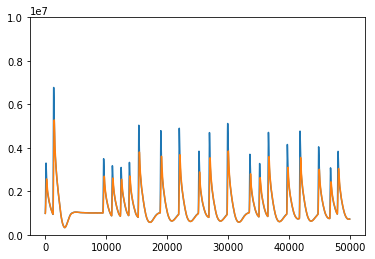

In [24]:
plt.plot(active_region.loops[100].time,active_region.loops[100].electron_temperature[:,:].mean(axis=1))
plt.plot(active_region.loops[100].time,active_region.loops[100].ion_temperature[:,:].mean(axis=1))
#plt.xlim(2e4,3e4)
plt.ylim(0,1e7)

In [25]:
active_region.save('/storage-home/w/wtb2/data/hi_c_simulation/field_checkpoint')

## Computing Intensities
Ultimately, we want to compute the intensity as a function $\theta_x,\theta_y$ and time for the whole AR. We can do this most easily by computing the 171 intensity for each loop at each time and space coordinate, and then constructing a histogram of loop coordinates (in HPC), weighted by the intensity values, at each timestep. 

## Sandbox

In [ ]:
s = Strand('/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/loop000200/')

In [ ]:
plot_strand(s,start=0,stop=1000,step=2,limits={'velocity':(-3e6,3e6),'temperature':(0,0.8),
                                                'density':(1e9,1e12),'pressure':(0.05,20)})

In [ ]:
anim = animate_strand(s,start=0,stop=1000,step=2,limits={'velocity':(-3e6,3e6),'temperature':(0,0.8),
                                                         'density':(1e9,1e12),'pressure':(0.05,20)}, interval=20)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
i_start = 0
i_finish = 10001
i_step = 2
l = active_region.loops[200]
with h5py.File(parameter_savefile.format(l.name),'r') as hf:
    s = u.Quantity(hf['coordinate'],hf['coordinate'].attrs['unit'])
    t = u.Quantity(hf['time'][i_start:i_finish:i_step],hf['time'].attrs['unit'])
    Te = u.Quantity(hf['electron_temperature'][:,i_start:i_finish:i_step],
                    hf['electron_temperature'].attrs['unit'])
    n = u.Quantity(hf['density'][:,i_start:i_finish:i_step],hf['density'].attrs['unit'])
    v = u.Quantity(hf['velocity'][:,i_start:i_finish:i_step],hf['velocity'].attrs['unit'])
# Create grids
grid_s,grid_t = np.meshgrid(t.value,s.value)
# Create plots
# Electron temperature
fig = plt.figure(figsize=(15,8),)
ax = fig.add_subplot(3,1,1)
ax.set_ylabel(r'$T_e$ [K]')
ax.set_title(f'{l.name} $L={l.full_length.to(u.Mm):.2f}$')
im = ax.pcolormesh(grid_s, grid_t, Te,cmap='plasma',vmin=5e5,vmax=8e6)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
## Density
ax = fig.add_subplot(3,1,2)
ax.set_ylabel(r'$n$ [cm$^{-3}$]')
im = ax.pcolormesh(grid_s, grid_t, n,cmap='plasma',norm=matplotlib.colors.LogNorm(vmin=1e8,vmax=1e12),)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
## Velocity
ax = fig.add_subplot(3,1,3)
ax.set_ylabel(r'$v$ [cm/s]')
ax.set_xlabel(r'$t$ [s]')
im = ax.pcolormesh(grid_s, grid_t, v,cmap='RdBu_r',vmin=-3e6,vmax=3e6,)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
plt.tight_layout()

In [ ]:
# Bound indices
i_start = 4000
i_finish = 6000
i_step = 2
# Read data
short_loops = [l for l in active_region.loops if l.full_length < 20*u.Mm]
with PdfPages('bad_loops_report.pdf') as pdf:
    with ProgressBar(len(short_loops), ipython_widget=True,) as prog:
        for i,l in enumerate(short_loops):
            with h5py.File(parameter_savefile.format(l.name),'r') as hf:
                s = u.Quantity(hf['coordinate'],hf['coordinate'].attrs['unit'])
                t = u.Quantity(hf['time'][i_start:i_finish:i_step],hf['time'].attrs['unit'])
                Te = u.Quantity(hf['electron_temperature'][:,i_start:i_finish:i_step],
                                hf['electron_temperature'].attrs['unit'])
                n = u.Quantity(hf['density'][:,i_start:i_finish:i_step],hf['density'].attrs['unit'])
                v = u.Quantity(hf['velocity'][:,i_start:i_finish:i_step],hf['velocity'].attrs['unit'])
            # Create grids
            grid_s,grid_t = np.meshgrid(t.value,s.value)
            # Create plots
            # Electron temperature
            fig = plt.figure(figsize=(15,8),)
            ax = fig.add_subplot(3,1,1)
            ax.set_ylabel(r'$T_e$ [K]')
            ax.set_title(f'{l.name} $L={l.full_length.to(u.Mm):.2f}$')
            im = ax.pcolormesh(grid_s, grid_t, Te,cmap='plasma',vmin=5e5,vmax=8e6)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            ## Density
            ax = fig.add_subplot(3,1,2)
            ax.set_ylabel(r'$n$ [cm$^{-3}$]')
            im = ax.pcolormesh(grid_s, grid_t, n,cmap='plasma_r',norm=matplotlib.colors.LogNorm(vmin=5e8,vmax=1e10),)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            ## Velocity
            ax = fig.add_subplot(3,1,3)
            ax.set_ylabel(r'$v$ [cm/s]')
            ax.set_xlabel(r'$t$ [s]')
            im = ax.pcolormesh(grid_s, grid_t, v,cmap='RdBu_r',vmin=-5e6,vmax=5e6,)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            plt.tight_layout()
            pdf.savefig(fig,dpi=50)
            plt.close()
            prog.update()